<a href="https://colab.research.google.com/github/ernesto-miguez/Machine-Learning-training/blob/master/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#!pip install statsmodels --upgrade
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.0 MB/s 
     |████████████████████████████████| 9.8 MB 44.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import statsmodels
statsmodels.__version__

'0.13.1'

In [ ]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.464240
p-value: 0.124419


Null hypothesis of the ADF test: time series is non-stationary.

Since P-Value > 0.05 the null hypothesis cannot be rejected, so we go ahead with finding the order of differencing to make it stationary.

## 1. Find the order of differencing (d)

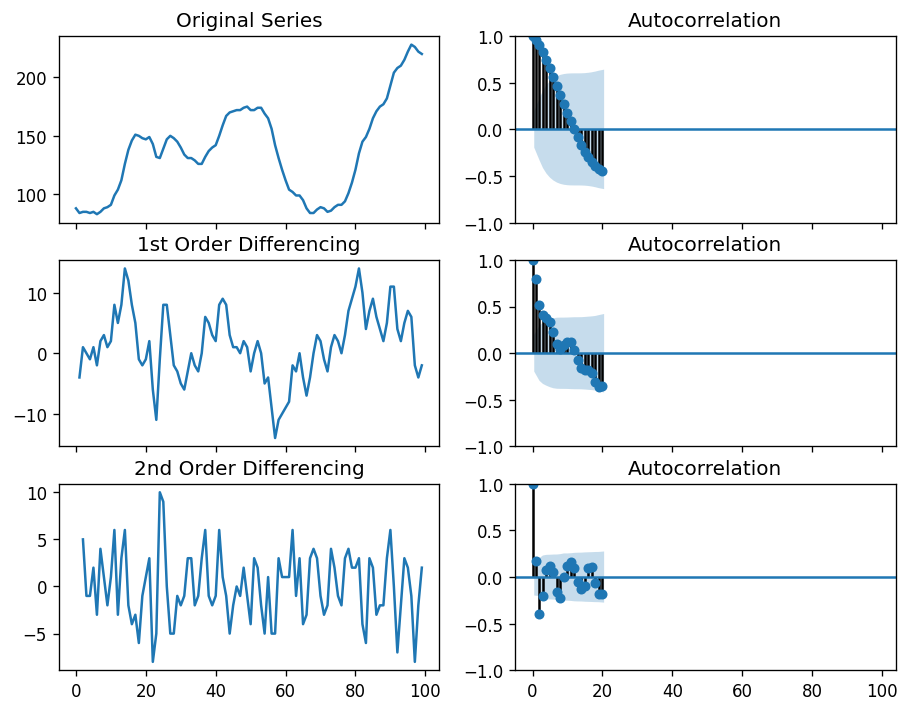

In [ ]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

As we can see, the 2nd order of differencing makes the series stationary, but in the autocorrelation graph we can see how it turns into a negative value fairly quick, which indicates that the series is over differrenced. Thus, **we choose the first level of differencing** even though the series is not perfectly stationary (weak stationarity)

In [ ]:
# #from pmdarima.arima.utils import ndiffs
# # ADF test
# print("ADF test = {}".format(ndiffs(df.value, test='adf')))

# # KPSS test
# print("KPSS test = {}".format(ndiffs(df.value, test='kpss')))

# # PP test
# print("PP test = {}".format(ndiffs(df.value, test='pp')))

In [ ]:
result = adfuller(df.value.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.722238
p-value: 0.070268


The ADF test for the first order of differencing rejects the null hypothesis at a 90% level of confidence, so we assume the series is now stationary.

## 2. Find the order of the AR term (p)

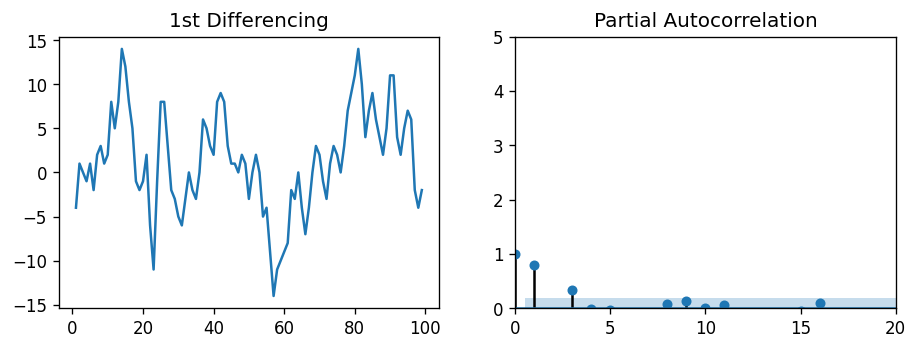

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
plot_pacf(df.value.diff().dropna(), ax=axes[1], method='yw')

plt.xlim([0,20])
plt.ylim([0,5])
plt.show()

P is set as 1 as the lag 1 is quite significant and the second one is barely significant

## 3. Find the order of the MA term (q)

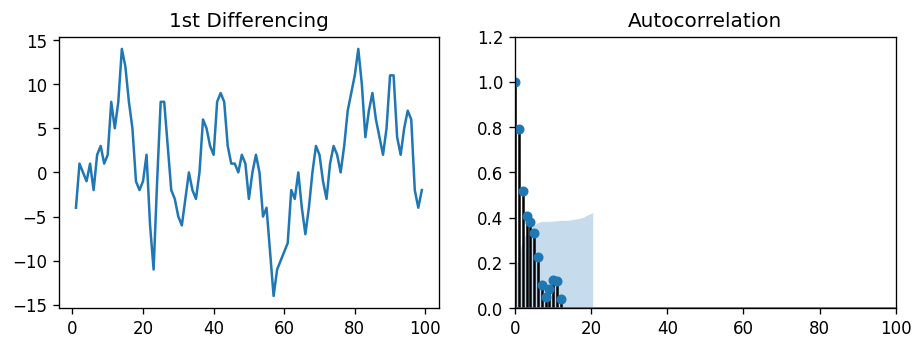

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.ylim([0,1.2])
plt.xlim([0,100])
plt.show()

Couple of lags are well above the significance line, so let’s tentatively fix q as 2.

## 4. Build the ARIMA model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
#from statsmodels.tsa.arima_model import ARIMA

# 1, 1, 2 ARIMA model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Sun, 16 Jan 2022   AIC                            516.253
Time:                        00:27:08   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

The MA2 term seems insignificant since the coefficient is close to 0 and the p-value shows it's highly insignificant. So let's remove the MA2 term by building a new model (1,1,1)

In [ ]:
# 1, 1, 1 ARIMA model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -254.150
Date:                Sun, 16 Jan 2022   AIC                            514.300
Time:                        00:27:08   BIC                            522.086
Sample:                             0   HQIC                           517.450
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6504      0.090      7.258      0.000       0.475       0.826
ma.L1          0.5256      0.088      5.994      0.000       0.354       0.697
sigma2         9.7934      1.405      6.970      0.0

Let's plot the residuals to ensure there are no patterns

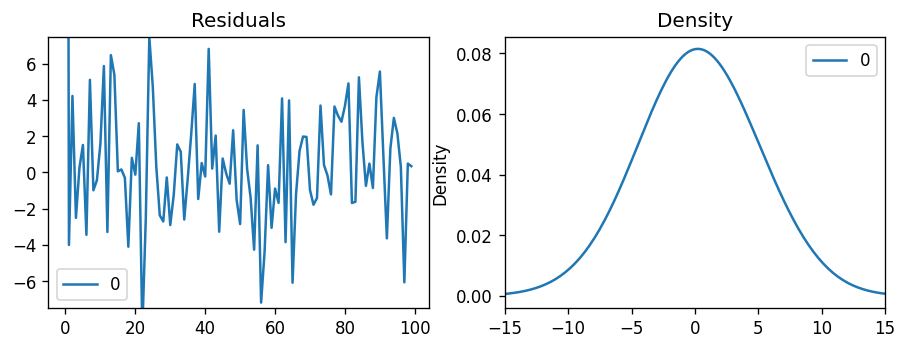

In [ ]:
# Plot the residuals
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0], ylim=[-7.5,7.5])
residuals.plot(kind='kde', title='Density', ax=ax[1], xlim=[-15,15])
plt.show()

The residual errors seem fine with near zero mean and uniform variance.
Let's plot the actual values vs the fitted ones

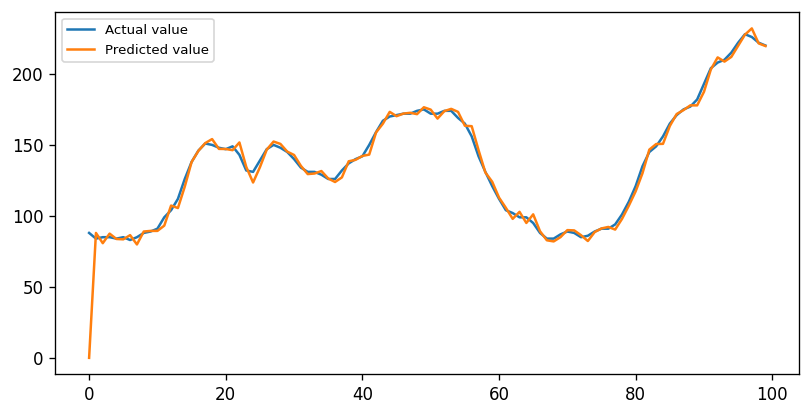

In [ ]:
# Actual vs fitted
plt.figure(figsize=(8,4))
plt.plot(df, label='Actual value')
plt.plot(model_fit.predict(start=0, end=99), label='Predicted value')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## 5. Out-of-Time Cross validation

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:85]
test = df.value[85:]

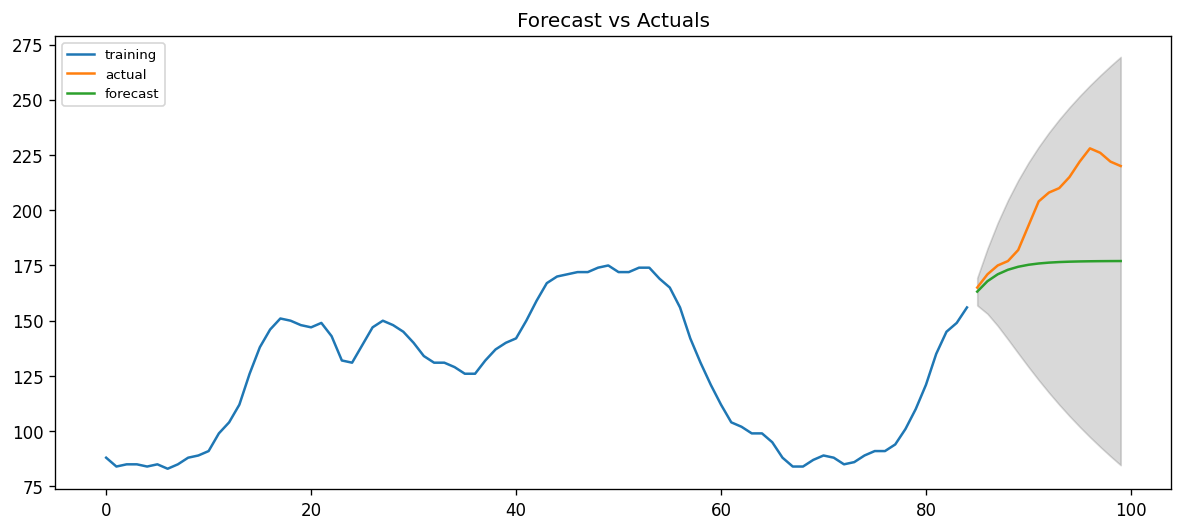

In [ ]:
# Build the ARIMA model
model = ARIMA(train, order=(1,1,1))
fitted = model.fit()

# Forecast
fc  = fitted.forecast(15, alpha=0.05) # 95% conf
conf = fitted.get_forecast(15).conf_int()

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf['lower value'], index=test.index)
upper_series = pd.Series(conf['upper value'], index=test.index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

From the chart, the ARIMA(1,1,1) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

But each of the predicted forecasts is consistently below the actuals. That means, by adding a small constant to our forecast, the accuracy will certainly improve. So, there is definitely scope for improvement.

Let's increase the order of differencing to 2 (d=2) and increase the autoregressive order to 3 (p=3)

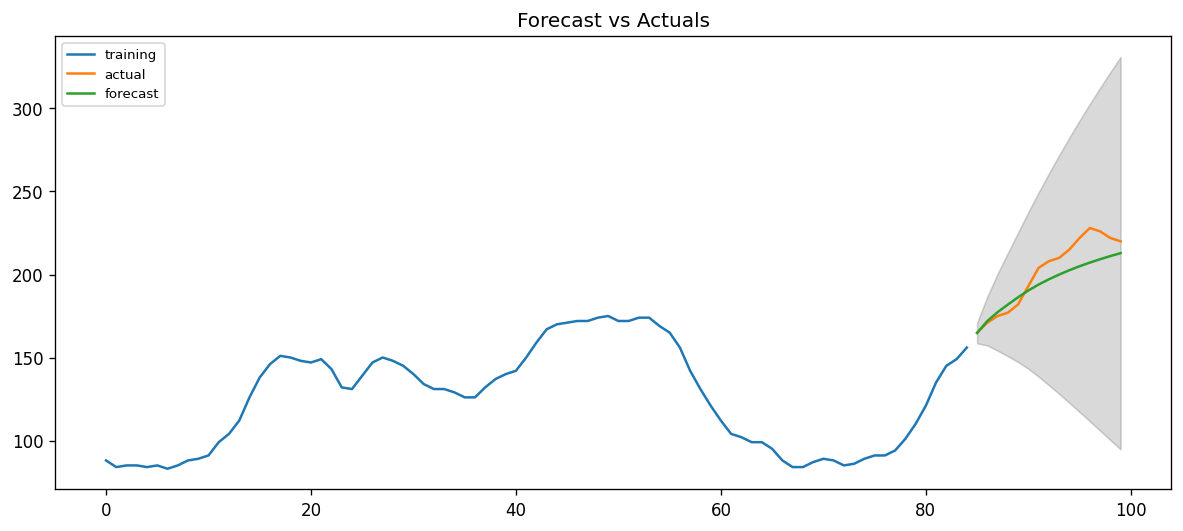

In [ ]:
# Build the ARIMA model
model = ARIMA(train, order=(3,2,1))
fitted = model.fit()

# Forecast
fc  = fitted.forecast(15, alpha=0.05) # 95% conf
conf = fitted.get_forecast(15).conf_int()


# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf['lower value'], index=test.index)
upper_series = pd.Series(conf['upper value'], index=test.index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   85
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -214.430
Date:                Sun, 16 Jan 2022   AIC                            438.860
Time:                        00:41:53   BIC                            450.954
Sample:                             0   HQIC                           443.719
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1365      0.132      8.603      0.000       0.878       1.395
ar.L2         -0.5883      0.151     -3.896      0.000      -0.884      -0.292
ar.L3          0.3022      0.128      2.359      0.0

## 6. Accuracy metrics for Time Series Forecast

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.


{'acf1': 0.858765484125107,
 'corr': 0.9734774234367487,
 'mae': 8.764661546663195,
 'mape': 0.0410976026758785,
 'me': -7.105780770048379,
 'minmax': 0.04099873710171886,
 'mpe': -0.03176842115774857,
 'rmse': 10.669308479537737}

## 7. Auto Arima Forecast in Python

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',          # Use adftest to find optimal 'd'
                      max_p=3, max_q=3,    # Maximum p and q
                      m=1,                 # Frequency of the series
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=525.587, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=533.474, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=532.437, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=525.893, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=531.477, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=515.248, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=513.459, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=515.284, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=511.465, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=530.444, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=513.291, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=513.256, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=523.592, Time=0.03 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time

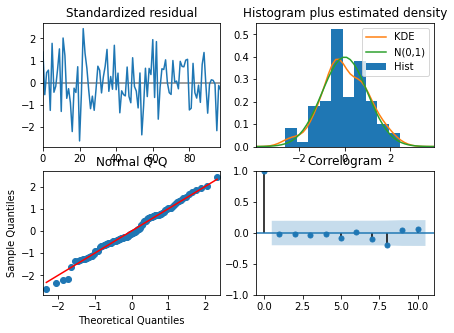

In [ ]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

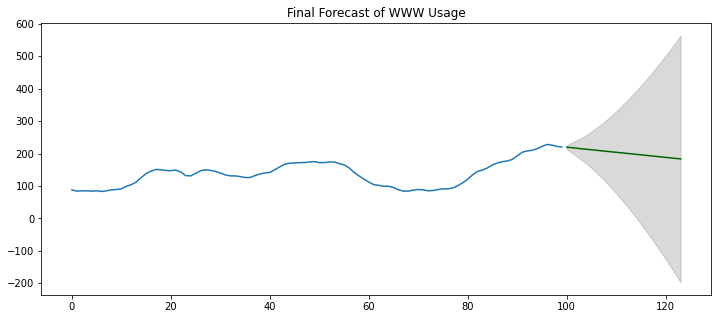

In [ ]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12,5))
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

## 8. SARIMA model 

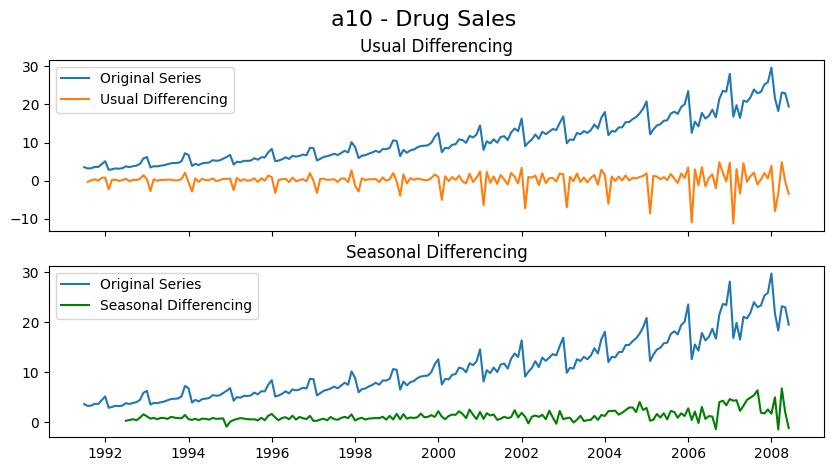

In [ ]:
# Import
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

## 9. Build SARIMA model

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=1.58 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.48 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.38 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.32 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=5.28 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=1.36 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.559, Time=5.23 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.33 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=1.37 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.38 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.70 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -254.030
Date:                            Sun, 16 Jan 2022   AIC                            524.060
Time:                                    00:52:57   BIC                            550.120
Sample:                                         0   HQIC                           534.615
                                            - 204                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0052      0.009      0.564      0.573      -0.013       0.023
ar.L1          0.9757      0.018     52.828      0.000       0.939       1.012
ma.L1         -0.8963      0.056    -15.948      0.000      -1.006      -0.786
ma.L2          0.2059      0.058      3.578      0.000       0.093       0.319
ar.S.L12       0.8440      0.174      4.852      0.000       0.503       1.185
ma.S.L12      -1.5566      0.192     -8.097      0.000      -1.933      -1.180
ma.S.L24       0.7293      0.113      6.437      0.000       0.507       0.951
sigma2         0.7549      0.063     12.065      0.000       0.632       0.878
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):               142.52
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):              14.49   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

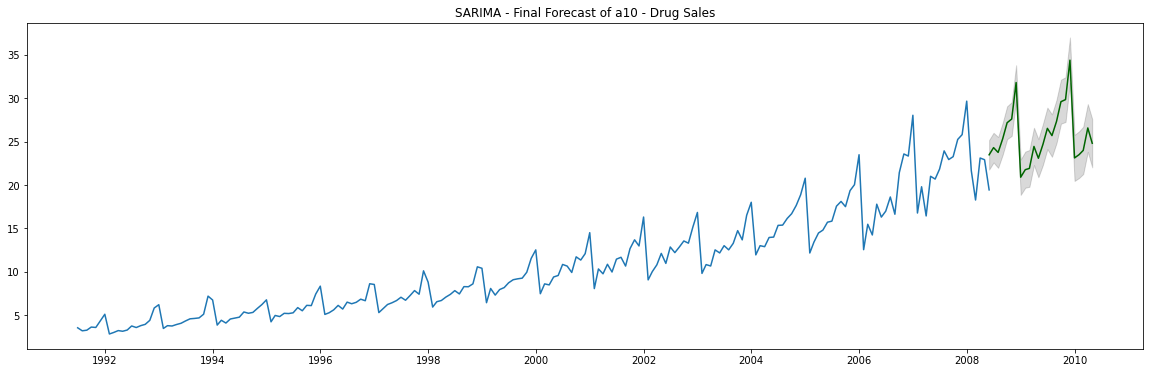

In [ ]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(20,6))
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

## 10. SARIMAX model
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ (15)


In [1]:
# Import Data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')

## 11. Exogenous variable

In [2]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.

## 12. Build SARIMAX model

In [6]:
import pmdarima as pm

sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                        start_p=1, start_q=1,
                        test='adf',
                        max_p=3, max_q=3, m=12,
                        start_P=0, seasonal=True,
                        error_action='ignore',
                        supress_warnings=True,
                        stepwise=True)

sxmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -273.339
Date:                            Sun, 16 Jan 2022   AIC                            560.677
Time:                                    22:50:16   BIC                            583.870
Sample:                                07-01-1991   HQIC                           570.060
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.0168      0.013      1.261      0.207      -0.009       0.043
seasonal_index    10.9043      1.377      7.920      0.000       8.206      13.603
ar.L1             -0.2033      0.060     -3.401      0.001      -0.320      -0.086
ma.L1             -0.6795      0.050    -13.560      0.000      -0.778      -0.581
ar.S.L12           0.8668      0.077     11.299      0.000       0.716       1.017
ma.S.L12          -0.3957      0.123     -3.225      0.001      -0.636      -0.155
sigma2             0.8253      0.051     16.204      0.000       0.725       0.925
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               215.24
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.54   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 13. Forecast into the next 24 months

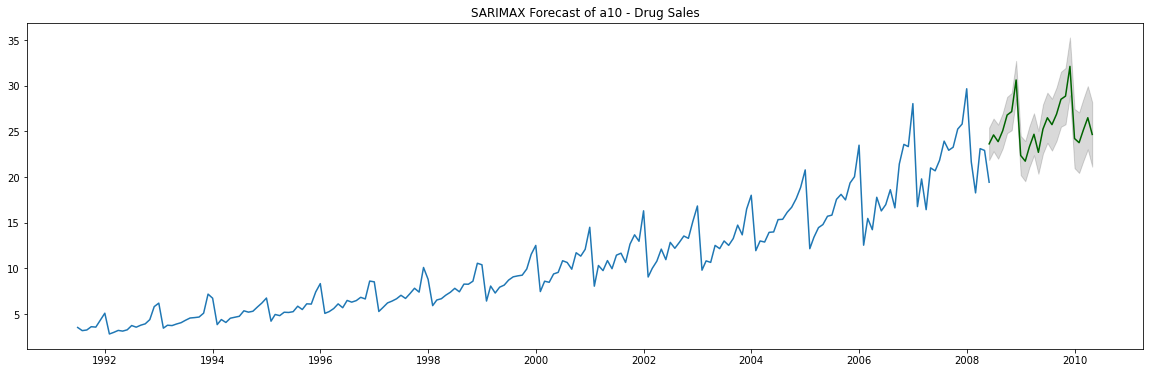

In [17]:
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index['seasonal'], 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(20,6))
plt.plot(data['value'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.show()